In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Install imbalanced-learn if not installed
try:
    from imblearn.over_sampling import RandomOverSampler
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install imbalanced-learn   
    from imblearn.over_sampling import RandomOverSampler

2024-12-17 03:50:00.874726: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 03:50:00.879698: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-17 03:50:00.926664: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-17 03:50:00.974455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734393001.022116   76987 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734393001.03

In [2]:
# Step 1: Load Data
categories = ['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']
data_paths = {
    category: glob.glob(f"./augmented-alzheimer-mri-dataset-v2/data/val/{category}/*")
    for category in categories
}

data = []
labels = []

for i, category in enumerate(categories):
    for file_path in data_paths[category]:
        data.append(file_path)
        labels.append(i)

In [3]:
# Step 2: Handle Data Imbalance (Oversampling)
data = np.array(data)   
labels = np.array(labels)

# Oversample minority classes
ros = RandomOverSampler(random_state=42)
data_resampled, labels_resampled = ros.fit_resample(data.reshape(-1, 1), labels)
data_resampled = data_resampled.ravel()

In [4]:

# Step 3: Train-test Split
data_train, data_val, labels_train, labels_val = train_test_split(
    data_resampled, labels_resampled, test_size=0.2, stratify=labels_resampled, random_state=42
)

In [5]:

# Step 4: Data Preprocessing
def preprocess_image(file_path):
    import tensorflow as tf
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.vgg16.preprocess_input(image)
    return image

def create_dataset(file_paths, labels):
    import tensorflow as tf
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


In [6]:
train_dataset = create_dataset(data_train, labels_train)
val_dataset = create_dataset(data_val, labels_val)

2024-12-17 03:50:03.980603: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-12-17 03:50:03.980638: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: miralasgar-Latitude-3520
2024-12-17 03:50:03.980644: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: miralasgar-Latitude-3520
2024-12-17 03:50:03.980778: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 470.256.2
2024-12-17 03:50:03.980797: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 470.256.2
2024-12-17 03:50:03.980801: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 470.256.2


In [7]:
# Step 5: Build the VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Step 6: Training the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 1606s 5s/step - accuracy: 0.4055 - loss: 1.8862 - val_accuracy: 0.6285 - val_loss: 0.7770
Epoch 2/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 1594s 5s/step - accuracy: 0.6059 - loss: 0.8367 - val_accuracy: 0.6516 - val_loss: 0.6935
Epoch 3/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 1594s 5s/step - accuracy: 0.6534 - loss: 0.7345 - val_accuracy: 0.6914 - val_loss: 0.6339
Epoch 4/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 1593s 5s/step - accuracy: 0.6761 - loss: 0.6878 - val_accuracy: 0.7031 - val_loss: 0.6068
Epoch 5/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 1593s 5s/step - accuracy: 0.6916 - loss: 0.6513 - val_accuracy: 0.7344 - val_loss: 0.5708
Epoch 6/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 1593s 5s/step - accuracy: 0.7059 - loss: 0.6310 - val_accuracy: 0.7348 - val_loss: 0.5551
Epoch 7/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 1580s 5s/step - accuracy: 0.7330 - loss: 0.5838 - val_accuracy: 0.7699 - val_loss: 0.5196
Epoch 8/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 1574s 5s/step - accuracy: 0.7383 - loss: 0.5723 - 

In [9]:
# Step 7: Evaluate the Model
eval_results = model.evaluate(val_dataset)
print(f"Validation Accuracy: {eval_results[1] * 100:.2f}%")

80/80 ━━━━━━━━━━━━━━━━━━━━ 324s 4s/step - accuracy: 0.8441 - loss: 0.3476
Validation Accuracy: 84.69%


In [10]:
# Step 8: Performance Metrics
# Predictions on validation set
y_true = labels_val
y_pred = np.argmax(model.predict(val_dataset), axis=-1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Validation Accuracy: {accuracy * 100:.2f}%')
print(f'Validation Precision: {precision * 100:.2f}%')
print(f'Validation Recall: {recall * 100:.2f}%')
print(f'Validation F1-Score: {f1 * 100:.2f}%')

80/80 ━━━━━━━━━━━━━━━━━━━━ 331s 4s/step
Validation Accuracy: 84.69%
Validation Precision: 84.44%
Validation Recall: 84.69%
Validation F1-Score: 84.42%


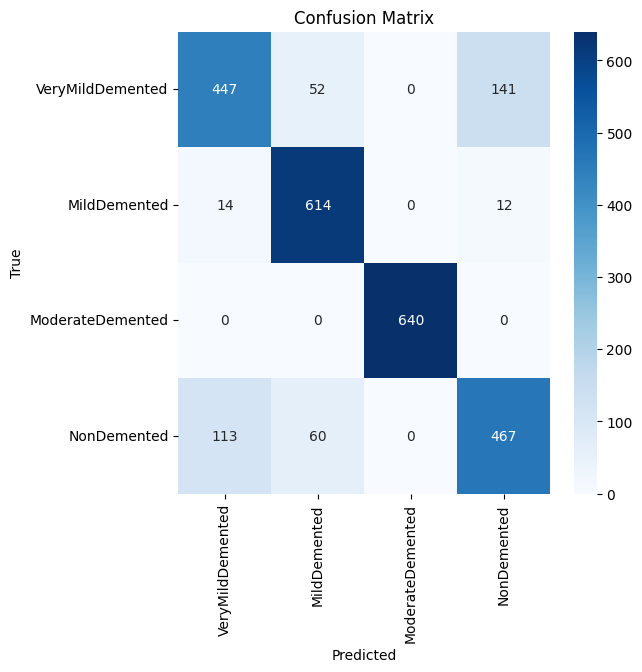

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

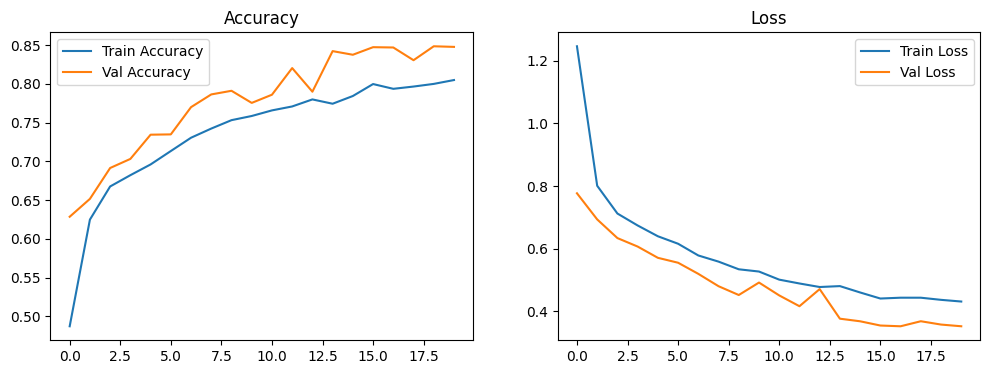

In [12]:
# Step 9: Plot Accuracy and Loss Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [13]:
# Step 10: Save the Model
model.save('alzheimer_vgg16_model.h5')

In [14]:
# Step 11: Fine-Tuning the Model
# Unfreeze Top Layers of VGG16
for layer in base_model.layers[:15]:  # Keep lower layers frozen
    layer.trainable = False
for layer in base_model.layers[15:]:  # Unfreeze top layers
    layer.trainable = True

In [15]:
# Recompile the Model
from tensorflow.keras.optimizers import Adam



fine_tune_lr = 1e-5
model.compile(optimizer=Adam(learning_rate=fine_tune_lr), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


In [16]:
# Fine-tune the Model
history_fine_tune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  # Additional epochs for fine-tuning
    callbacks=[early_stopping]
)


Epoch 1/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 1779s 6s/step - accuracy: 0.8040 - loss: 0.4351 - val_accuracy: 0.8703 - val_loss: 0.2992
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 1814s 6s/step - accuracy: 0.8535 - loss: 0.3204 - val_accuracy: 0.9184 - val_loss: 0.2028
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 1775s 6s/step - accuracy: 0.8767 - loss: 0.2666 - val_accuracy: 0.9215 - val_loss: 0.2024
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 1818s 6s/step - accuracy: 0.9086 - loss: 0.2114 - val_accuracy: 0.9422 - val_loss: 0.1564
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 1784s 6s/step - accuracy: 0.9182 - loss: 0.1874 - val_accuracy: 0.9492 - val_loss: 0.1324
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 5316s 17s/step - accuracy: 0.9342 - loss: 0.1655 - val_accuracy: 0.9676 - val_loss: 0.0911
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 1838s 6s/step - accuracy: 0.9447 - loss: 0.1405 - val_accuracy: 0.9758 - val_loss: 0.0777
Epoch 8/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 1814s 6s/step - accuracy: 0.9537 - loss: 0.1198 -

In [17]:
# Evaluate Fine-tuned Model
eval_results_fine_tune = model.evaluate(val_dataset)
print(f"Fine-tuned Validation Accuracy: {eval_results_fine_tune[1] * 100:.2f}%")


80/80 ━━━━━━━━━━━━━━━━━━━━ 328s 4s/step - accuracy: 0.9842 - loss: 0.0395
Fine-tuned Validation Accuracy: 98.24%


In [18]:
# Performance Metrics after Fine-tuning
y_true_fine_tune = labels_val
y_pred_fine_tune = np.argmax(model.predict(val_dataset), axis=-1)

accuracy_fine_tune = accuracy_score(y_true_fine_tune, y_pred_fine_tune)
precision_fine_tune = precision_score(y_true_fine_tune, y_pred_fine_tune, average='weighted')
recall_fine_tune = recall_score(y_true_fine_tune, y_pred_fine_tune, average='weighted')
f1_fine_tune = f1_score(y_true_fine_tune, y_pred_fine_tune, average='weighted')

print(f'Fine-Tuned Validation Accuracy: {accuracy_fine_tune * 100:.2f}%')
print(f'Fine-Tuned Validation Precision: {precision_fine_tune * 100:.2f}%')
print(f'Fine-Tuned Validation Recall: {recall_fine_tune * 100:.2f}%')
print(f'Fine-Tuned Validation F1-Score: {f1_fine_tune * 100:.2f}%')

80/80 ━━━━━━━━━━━━━━━━━━━━ 328s 4s/step
Fine-Tuned Validation Accuracy: 98.24%
Fine-Tuned Validation Precision: 98.30%
Fine-Tuned Validation Recall: 98.24%
Fine-Tuned Validation F1-Score: 98.24%


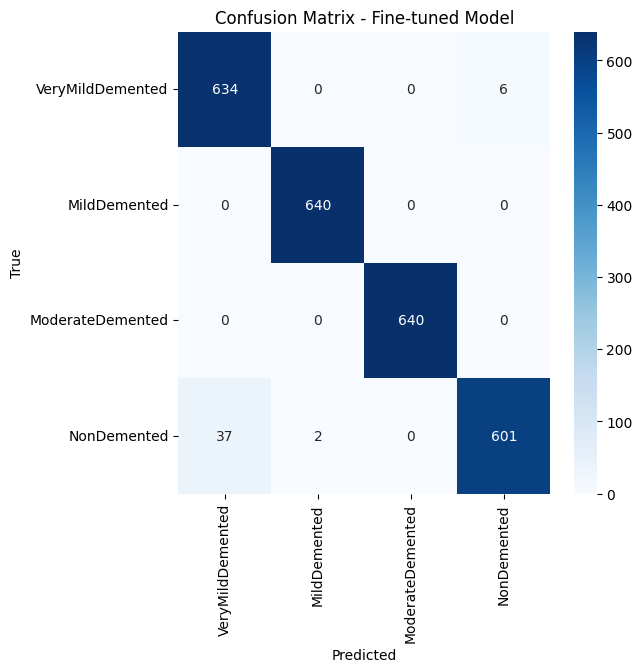

In [19]:

# Confusion Matrix after Fine-tuning
cm_fine_tune = confusion_matrix(y_true_fine_tune, y_pred_fine_tune)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_fine_tune, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Fine-tuned Model')
plt.show()

In [20]:

# Save the fine-tuned model
model.save('fine_tuned_vgg16.h5')

# Save the trained model in .h5 format
model.save('fine_tuned_vgg16-1.h5', save_format='h5')

model.save('fine_tuned_vgg16.keras')